In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 데이터셋 불러오기

In [ ]:
df = pd.read_pickle('./dataset/00_feature_with_label.pkl')
df.head()

,IMP_TYPE_OF_DECLARATION_1,IMP_TYPE_OF_DECLARATION_2,TRD_TIN_2,TRD_NAME_2,TRD_COUNTRY_2,TRD_ADDR_2,CUS_SHIPMENT_SPEC_4,CUS_TOTAL_NUMBER_OF_ITEMS_5,CUS_TOTAL_NUMBER_OF_PACKAGES_6,CUS_REF_NO_7,CON_TIN_8,CON_NAME_8,CON_COUNTRY_8,CON_ADDR_8,PER_TIN_9,PER_NAME_9,PER_COUNTRY_9,PER_ADDR_9,IMP_TRADING_COUNTRY_11,VAL_FINANCIAL_VALUE_12,VAL_CURRENCY_12,DNT_TIN_14,DNT_NAME_14,DNT_COUNTRY_14,DNT_ADDR_14,IMP_CNT_OF_DISPATCH_EXP_CD_15,IMP_COUNTRY_OF_ORIGIN_16,IMP_CONTAINER_FLAG_19,DEL_DELIVERY_TERM_CODE_20,DEL_PLACE_OF_DELIVERY_20,TOT_CURRENCY_22,TOT_FINANCIAL_VALUE_22,IMP_EXCHANGE_RATE_23,IMP_INLAND_TRANSPORT_MODE_25,IMP_TRANSPORT_MODE_AT_BODR_26,LOD_LOCATION_NAME_27,LOC_LOCATION_NAME_30,OFF_CODE_30,GDS_GOODS_DESCRIPTION_31,GDS_ITEM_NUMBER_32,COM_COMBINED_NOMENCLATURE_33,IDG_COUNTRY_OF_ORIGIN_34,GDS_GROSS_MASS_35,PRF_PREFERENCE_CODE_1,PRF_PREFERENCE_CODE_2,PRF_PREFERENCE_CODE_3,PRF_PREFERENCE_CODE_4,IDG_PROCEDURE_REQUESTED_37,IDG_PREVIOUS_PROCEDURE_37,IDG_ADD_NATIONAL_PROC_37,IDG_NET_MASS_38,IDG_QUOTA,ZQNTY,ZAUXUOM,FIN_FINANCIAL_VALUE_42,COR_FINANCIAL_VALUE,COR_CURRENCY,COV_CUST_VALUE_METHOD,STC_FINANCIAL_VALUE_46,IDG_STAT_VALUE_VAL_METH_46,CAL_TYPE_OF_TAX_47,CAL_TAX_BASE_47,CAL_RATE_OF_TAX_47,CAL_ADDITIONAL_RATE_OF_TAX_47,PAM_FINANCIAL_VALUE_47,CAL_METHOD_OF_PAYMENT_47,IMP_DATE_OF_DECLARATION_54,REP_TIN_54,PERSON_NAME_54,PERSON_POSITION_54,GEND_REFERENCE_54,GEND_ISSUE_DATE_54,ACCEPTANCE_DATE,LABEL
0,ИМ,NaN,NaN,ООО ВИП-ТРАНС,RU,НИЖНЕВАРТОВСК КУЗОВАТКИНА ДОМ 5 СТРОЕНИЕ 3,NaN,1,64.0,762235/140217/0000189,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,345737.87,TJS,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,RU,0.0,CPT,СТ.ОРСК-НОВЫЙ ГОРОД,RUB,2046973.0,0.1347,20.0,20.0,NaN,Ж/Д ДЖ.РАСУЛОВ,762235,"ПЛИТЫ ДРЕВЕСНО-СТРУЖЕЧНЫЕ, ЛАМИНИРОВАННЫЕ ГОСТ...",1,4410110009,RU,128000.0,О,Г,О,О,40,0,44,121145.0,NaN,185.52,113.0,2046973.0,345737.87,TJS,1.0,43705.0,1.0,10.0,345737.87,70.00,SP,553.76,БН,20170214,510000091,ВАХОБОВ ШАВКАТ ТУРСУНБОЕВИЧ,СПЕЦИАЛИСТ ПО Т/О,СГ01/007,20150624.0,"14.02.17 11:55:18,551000000",0
1,ИМ,NaN,NaN,ООО ВИП-ТРАНС,RU,НИЖНЕВАРТОВСК КУЗОВАТКИНА ДОМ 5 СТРОЕНИЕ 3,NaN,1,64.0,762235/140217/0000189,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,345737.87,TJS,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,RU,0.0,CPT,СТ.ОРСК-НОВЫЙ ГОРОД,RUB,2046973.0,0.1347,20.0,20.0,NaN,Ж/Д ДЖ.РАСУЛОВ,762235,"ПЛИТЫ ДРЕВЕСНО-СТРУЖЕЧНЫЕ, ЛАМИНИРОВАННЫЕ ГОСТ...",1,4410110009,RU,128000.0,О,Г,О,О,40,0,44,121145.0,NaN,185.52,113.0,2046973.0,345737.87,TJS,1.0,43705.0,1.0,20.0,345737.87,5.00,AD,17286.89,УН,20170214,510000091,ВАХОБОВ ШАВКАТ ТУРСУНБОЕВИЧ,СПЕЦИАЛИСТ ПО Т/О,СГ01/007,20150624.0,"14.02.17 11:55:18,551000000",0
2,ИМ,NaN,NaN,ООО ВИП-ТРАНС,RU,НИЖНЕВАРТОВСК КУЗОВАТКИНА ДОМ 5 СТРОЕНИЕ 3,NaN,1,64.0,762235/140217/0000189,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,345737.87,TJS,620010597,ООО ЧИТГАР,TJ,ИСТАРАВШАН БУСТОН 107,RU,RU,0.0,CPT,СТ.ОРСК-НОВЫЙ ГОРОД,RUB,2046973.0,0.1347,20.0,20.0,NaN,Ж/Д ДЖ.РАСУЛОВ,762235,"ПЛИТЫ ДРЕВЕСНО-СТРУЖЕЧНЫЕ, ЛАМИНИРОВАННЫЕ ГОСТ...",1,4410110009,RU,128000.0,О,Г,О,О,40,0,44,121145.0,NaN,185.52,113.0,2046973.0,345737.87,TJS,1.0,43705.0,1.0,30.0,345737.87,18.00,AD,62232.82,БН,20170214,510000091,ВАХОБОВ ШАВКАТ ТУРСУНБОЕВИЧ,СПЕЦИАЛИСТ ПО Т/О,СГ01/007,20150624.0,"14.02.17 11:55:18,551000000",0
3,ИМ,NaN,NaN,""" М/С АКИДЖ ДУТЕ МИЛЛС ЛТД"",Ч/З БАНДАР АБАС П/...",BD,АББАС,NaN,1,1213.0,762241/140217/0100665,560002910,"ООО ""РОСТОИ СУГД""",TJ,ГУЛИСТОН И.СОМОНИ 1,560002910,"ООО ""РОСТОИ СУГД""",TJ,ГУЛИСТОН И.СОМОНИ 1,AE,346493.04,TJS,560002910,"ООО ""РОСТОИ СУГД""",TJ,ГУЛИСТОН И.СОМОНИ 1,BD,BD,0.0,CIP,ГУЛИСТОН,USD,43800.0,7.9108,20.0,20.0,NaN,Ж/Д ХУДЖАНД,762241,"ВОЛОКНО СИНТЕТИЧЕСКОЕ,ИЗ ДЖУТА",1,5307200000,BD,46640.0,О,А,О,О,40,0,0,45000.0,NaN,NaN,NaN,43800.0,346493.04,TJS,1.0,43800.0,1.0,10.0,346493.04,70.00,SP,553.76,БН,20170214,510000091,САЙФИЕВА МАВЗУНА ШАРИФДЖАНОВНА,СПЕЦИАЛИСТ,СГ/01/007

## 파생변수(PRF_PREFERENCE_CODE23, hs-cord 품목별,월)

### PRF_PREFERENCE_CODE23

In [ ]:
# 상관계수가 높은 칼럼 2개를 합쳐서 파생변수 생성
df['PRF_PREFERENCE_CODE23']=df['PRF_PREFERENCE_CODE_2']+df['PRF_PREFERENCE_CODE_3']

### hs-cord 품목별

In [ ]:
# hs-cord 품목별로 분류
# 숫자 문자화
df['COM_COMBINED_NOMENCLATURE_33']=df['COM_COMBINED_NOMENCLATURE_33'].astype('str')
# 칼럼 생성
df.insert(40,'HS_CORD',0)

In [ ]:
df3 =df.iloc[:,40:42]
df3.head()

In [ ]:
# COM_COMBINED_NOMENCLATURE_33 앞에 2자리만 hs-cord 칼럼으로 생성, 너무 오래 걸려서 칼럼 추출 후 concat
for i in range(len(df3)):
  df3.iloc[i,0]=df3.iloc[i,1][0:2]
for i in range(len(df)):
  df3.iloc[i,0]=df3.iloc[i,1][0:2]

In [ ]:
# 영문 오타 있을 수 있음
df3.insert(0,'HS_CORD_C',
            df3.apply(lambda x: 
            'animal' if x['HS_CORD'] in ['01','02','03','04','05']
            else 'vegetable' if x['HS_CORD'] in ['06','07','08','09','10','11','12','13','14']
            else 'fats_olis' if x['HS_CORD'] in ['15']
            else 'foodstuffs' if x['HS_CORD'] in ['16','17','18','19','20','21','22','23','24']
            else 'mineral' if x['HS_CORD'] in ['25','26','27']
            else 'chemical' if x['HS_CORD'] in ['28','29','30','31','32','33','34','35','36','37','38']
            else 'plastic_rubber' if x['HS_CORD'] in ['39','40']
            else 'leathers' if x['HS_CORD'] in ['41','42','43']
            else 'wood' if x['HS_CORD'] in ['44','45','46']
            else 'pulp' if x['HS_CORD'] in ['47','48','49']
            else 'textiles' if x['HS_CORD'] in ['50','51','52','53','54','55','56','57','58','59','60','61','62','63']
            else 'clothing' if x['HS_CORD'] in ['64','65','66','67']
            else 'ceramic' if x['HS_CORD'] in ['68','69','70']
            else 'jewelry' if x['HS_CORD'] in ['71']
            else 'nonmetals' if x['HS_CORD'] in ['72','72','73','74','75','76','77','78','79','80','81','82','83']
            else 'machinery' if x['HS_CORD'] in ['84','85']           
            else 'big_machinery' if x['HS_CORD'] in ['86','87','88','89'] 
            else 'picture_medical_machine' if x['HS_CORD'] in ['90','91','92']
            else 'arsenal' if x['HS_CORD'] in ['93']
            else 'etc' if x['HS_CORD'] in ['94','95','96']
            else 'art', axis =1))

In [ ]:
df =pd.concat([df,df3.HS_CORD_C],axis=1)

### 월

In [ ]:
df_date=df.copy()

In [ ]:
acc=df_date.ACCEPTANCE_DATE.str.split(' ', expand=True)
df_date['DATE']=acc[0] # ACCEPTANCE_DATE에서 년월일만 분리
df_date['DATE']=df_date['DATE'].astype('str')

acc_c=df_date['DATE'].str.split('.',expand=True)
df_date['DATE']='20'+acc_c[2]+acc_c[1]+acc_c[0] # 순서를 년월일 즉, 0,1,2 순으로 잡음 ex) 20170119 

In [ ]:
df_date["YEAR"]=df_date["DATE"].str[0:4]
df_date["MONTH"]=df_date["DATE"].str[4:6]
df_date["DAY"]=df_date["DATE"].str[6:8]

In [ ]:
df = pd.concat([df,df_date.MONTH], axis=1)

In [ ]:
idf = df.loc[df.LABEL==1]
idf.head()

,IMP_TYPE_OF_DECLARATION_1,IMP_TYPE_OF_DECLARATION_2,TRD_TIN_2,TRD_NAME_2,TRD_COUNTRY_2,TRD_ADDR_2,CUS_SHIPMENT_SPEC_4,CUS_TOTAL_NUMBER_OF_ITEMS_5,CUS_TOTAL_NUMBER_OF_PACKAGES_6,CUS_REF_NO_7,CON_TIN_8,CON_NAME_8,CON_COUNTRY_8,CON_ADDR_8,PER_TIN_9,PER_NAME_9,PER_COUNTRY_9,PER_ADDR_9,IMP_TRADING_COUNTRY_11,VAL_FINANCIAL_VALUE_12,VAL_CURRENCY_12,DNT_TIN_14,DNT_NAME_14,DNT_COUNTRY_14,DNT_ADDR_14,IMP_CNT_OF_DISPATCH_EXP_CD_15,IMP_COUNTRY_OF_ORIGIN_16,IMP_CONTAINER_FLAG_19,DEL_DELIVERY_TERM_CODE_20,DEL_PLACE_OF_DELIVERY_20,TOT_CURRENCY_22,TOT_FINANCIAL_VALUE_22,IMP_EXCHANGE_RATE_23,IMP_INLAND_TRANSPORT_MODE_25,IMP_TRANSPORT_MODE_AT_BODR_26,LOD_LOCATION_NAME_27,LOC_LOCATION_NAME_30,OFF_CODE_30,GDS_GOODS_DESCRIPTION_31,GDS_ITEM_NUMBER_32,COM_COMBINED_NOMENCLATURE_33,IDG_COUNTRY_OF_ORIGIN_34,GDS_GROSS_MASS_35,PRF_PREFERENCE_CODE_1,PRF_PREFERENCE_CODE_2,PRF_PREFERENCE_CODE_3,PRF_PREFERENCE_CODE_4,IDG_PROCEDURE_REQUESTED_37,IDG_PREVIOUS_PROCEDURE_37,IDG_ADD_NATIONAL_PROC_37,IDG_NET_MASS_38,IDG_QUOTA,ZQNTY,ZAUXUOM,FIN_FINANCIAL_VALUE_42,COR_FINANCIAL_VALUE,COR_CURRENCY,COV_CUST_VALUE_METHOD,STC_FINANCIAL_VALUE_46,IDG_STAT_VALUE_VAL_METH_46,CAL_TYPE_OF_TAX_47,CAL_TAX_BASE_47,CAL_RATE_OF_TAX_47,CAL_ADDITIONAL_RATE_OF_TAX_47,PAM_FINANCIAL_VALUE_47,CAL_METHOD_OF_PAYMENT_47,IMP_DATE_OF_DECLARATION_54,REP_TIN_54,PERSON_NAME_54,PERSON_POSITION_54,GEND_REFERENCE_54,GEND_ISSUE_DATE_54,ACCEPTANCE_DATE,LABEL,PRF_PREFERENCE_CODE23,HS_CORD_C,DATE_CUS_M,DATE_IMP_M
8217,ИМ,NaN,NaN,АМИН ТАДЖ ЧИНЕ,IR,МАШХАД,NaN,3,2170.0,762314/260117/0000047,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,IR,165706.86,TJS,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,IR,IR,0.0,CIP,ЯВАН,USD,21004.0,7.8893,20.0,20.0,NaN,Ж/Д СТ /ЯВАН/,762314,РОЛИКИ ПЛАСТМАССВЫЕ,1,3919909000,IR,28440.0,О,О,А,О,40,0,0,28440.0,NaN,NaN,NaN,16000.0,126228.80,TJS,NaN,16000.0,1.0,10.0,165706.86,70.0,SP,552.25,КТ,20170126,280005578,САЛИХОВА ДЖИЛЛО РУСТАМОВНА,СП.ПО Т\О,ХТ/02/0054,20120605.0,"26.01.17 16:16:05,218000000",1,ОА,plastic_rubber,01,01
8218,ИМ,NaN,NaN,АМИН ТАДЖ ЧИНЕ,IR,МАШХАД,NaN,3,2170.0,762314/260117/0000047,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,IR,165706.86,TJS,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,IR,IR,0.0,CIP,ЯВАН,USD,21004.0,7.8893,20.0,20.0,NaN,Ж/Д СТ /ЯВАН/,762314,РОЛИКИ ПЛАСТМАССВЫЕ,1,3919909000,IR,28440.0,О,О,А,О,40,0,0,28440.0,NaN,NaN,NaN,16000.0,126228.80,TJS,NaN,16000.0,1.0,20.0,126228.80,10.0,AD,12622.88,КТ,20170126,280005578,САЛИХОВА ДЖИЛЛО РУСТАМОВНА,СП.ПО Т\О,ХТ/02/0054,20120605.0,"26.01.17 16:16:05,218000000",1,ОА,plastic_rubber,01,01
8219,ИМ,NaN,NaN,АМИН ТАДЖ ЧИНЕ,IR,МАШХАД,NaN,3,2170.0,762314/260117/0000047,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,IR,165706.86,TJS,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,IR,IR,0.0,CIP,ЯВАН,USD,21004.0,7.8893,20.0,20.0,NaN,Ж/Д СТ /ЯВАН/,762314,РОЛИКИ ПЛАСТМАССВЫЕ,1,3919909000,IR,28440.0,О,О,А,О,40,0,0,28440.0,NaN,NaN,NaN,16000.0,126228.80,TJS,NaN,16000.0,1.0,30.0,138851.68,18.0,AD,24993.30,КТ,20170126,280005578,САЛИХОВА ДЖИЛЛО РУСТАМОВНА,СП.ПО Т\О,ХТ/02/0054,20120605.0,"26.01.17 16:16:05,218000000",1,ОА,plastic_rubber,01,01
8220,ИМ,NaN,NaN,АМИН ТАДЖ ЧИНЕ,IR,МАШХАД,NaN,3,2170.0,762314/260117/0000047,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,IR,165706.86,TJS,30024291,"ООО ""ИРФОН-РУСТАМ""",TJ,ДУШАНБЕ ЮЖНО ОБХОДНАЯ 3,IR,IR,0.0,CIP,ЯВАН,USD,21004.0,7.8893,20.0,20.0,NaN,Ж/Д СТ /ЯВАН/,762314,МЫЛО ХОЗЯЙСТВЕННОЕ,2,3401190000,IR,9.0,О,О,А,О,40,0,0,9.0,NaN,NaN,NaN,4.0,31.56,TJS,NaN,4.0,1.0,20.0,31.56,5.0,AD,1.58,КТ,20170126,280005578,САЛИХОВА ДЖИЛЛО РУСТАМОВНА,СП.ПО Т\О,ХТ/02/0054,20120605.0,"26.01.17 16:16:05,218000000",1,ОА,chemical,01,01
8221,ИМ,NaN,NaN,АМИН ТАДЖ ЧИНЕ,IR,МАШХАД,NaN,3,2170.0,76231

## barplot 시각화 함수
- 입력 파라미터
  - df => 시각화 하고자 하는 데이터가 포함된 데이터프레임
  - col_name => df 안에 내가 시각화하고자 하는 column의 이름
  - x_name => 그려지는 그래프의 x축의 이름
  - y_name => 그려지는 그래프의 y축의 이름
  - title => 그려지는 그래프의 제목
  - ratio_sort => True 입력 시 비율 순으로 내림차순, False 입력 시 내림차순으로 그래프 정렬. default값은 True
  - show_num => 표시하고자 하는 값의 개수. default값은 40

### 적발 비율 그래프(사용자함수)

In [ ]:
# 사용자 함수 작성 => plotly 형태로 출력하는 그래프, 적발 건수의 비율을 시각화

def show_ratio_bar(df, col_name, x_name, y_name, title, ratio_sort=True, show_num=40):
    idf = df.loc[df.LABEL==1] # 적발된 데이터만 추출한 데이터프레임
    a_index = idf[col_name].value_counts().index # 적발 df에서 입력한 column에 대한 값들의 index
    a = idf[col_name].value_counts() # 적발 df에서의 입력한 column에 대한 value들 전체
    b = df[col_name].value_counts()[a_index] # 전체 df에서 비교를 위해 a_index를 기반으로 한 value들 전체

    temp_ratio = [] # 적발 비율을 담기 위한 list
    temp_case = [] # 적발 건수를 담기 위한 list
    for anum, bnum in zip(a, b): # zip으로 적발건수, 전체 거래건수 출력
        temp_ratio.append(round((anum/bnum)*100,4))  # (적발건수/전체 거래건수) * 100 => 해당 항목에 대한 적발 비율. 계산 후 list에 추가
        temp_case.append(anum) # 단순 적발 건수를 list에 추가
      
    temp_df = pd.DataFrame([temp_ratio, temp_case], index=['ratio', 'casenum'], columns=a_index).T # 컬럼을 ratio(적발 비율), casenum(적발 건수)로 가지는 데이터프레임 생성

    if ratio_sort==True: # default 설정. 데이터프레임에 포함된 ratio 기준(내림차순)으로 정해진 데이터 개수만큼 그래프 출력
      res_df = temp_df.sort_values('ratio', ascending=False)[:show_num]
      fig = px.bar(x=res_df.index, y=list(res_df.ratio), text=list(res_df.casenum)) # x축을 시리즈의 인덱스로, y축을 시리즈의 데이터(적발 비율)로 설정하고 각 barplot에 건수 데이터 입력
      fig.update_layout(title=title, xaxis_title = x_name, yaxis_title = y_name) # 플롯 제목, x축 이름, y축 이름을 각각 입력받은 값으로 설정
      fig.show()

    elif ratio_sort==False: # default 외 별도 설정. 데이터프레임에 포함된 casenum 기준(내림차순)으로 정해진 데이터 개수만큼 그래프 출력
      res_df = temp_df.sort_values('casenum', ascending=False)[:show_num]
      fig = px.bar(x=res_df.index, y=list(res_df.ratio), text=list(res_df.casenum))
      fig.update_layout(title=title, xaxis_title = x_name, yaxis_title = y_name)
      fig.show()

In [ ]:
# 사이즈 조정

def show_ratio_bar_resize(df, col_name, x_name, y_name, title, ratio_sort=True, show_num=40):
    idf = df.loc[df.LABEL==1] # 적발된 데이터만 추출한 데이터프레임
    a_index = idf[col_name].value_counts().index # 적발 df에서 입력한 column에 대한 값들의 index
    a = idf[col_name].value_counts() # 적발 df에서의 입력한 column에 대한 value들 전체
    b = df[col_name].value_counts()[a_index] # 전체 df에서 비교를 위해 a_index를 기반으로 한 value들 전체

    temp_ratio = [] # 적발 비율을 담기 위한 list
    temp_case = [] # 적발 건수를 담기 위한 list
    for anum, bnum in zip(a, b): # zip으로 적발건수, 전체 거래건수 출력
        temp_ratio.append(round((anum/bnum)*100,4))  # (적발건수/전체 거래건수) * 100 => 해당 항목에 대한 적발 비율. 계산 후 list에 추가
        temp_case.append(anum) # 단순 적발 건수를 list에 추가
      
    temp_df = pd.DataFrame([temp_ratio, temp_case], index=['ratio', 'casenum'], columns=a_index).T # 컬럼을 ratio(적발 비율), casenum(적발 건수)로 가지는 데이터프레임 생성

    if ratio_sort==True: # default 설정. 데이터프레임에 포함된 ratio 기준(내림차순)으로 정해진 데이터 개수만큼 그래프 출력
      res_df = temp_df.sort_values('ratio', ascending=False)[:show_num]
      fig = px.bar(x=res_df.index, y=list(res_df.ratio), text=list(res_df.casenum)) # x축을 시리즈의 인덱스로, y축을 시리즈의 데이터(적발 비율)로 설정하고 각 barplot에 건수 데이터 입력
      fig.update_layout(title=title, xaxis_title = x_name, yaxis_title = y_name,
                        autosize=False, width=500, height=300) # 플롯 제목, x축 이름, y축 이름을 각각 입력받은 값으로 설정
      fig.show()

    elif ratio_sort==False: # default 외 별도 설정. 데이터프레임에 포함된 casenum 기준(내림차순)으로 정해진 데이터 개수만큼 그래프 출력
      res_df = temp_df.sort_values('casenum', ascending=False)[:show_num]
      fig = px.bar(x=res_df.index, y=list(res_df.ratio), text=list(res_df.casenum))
      fig.update_layout(title=title, xaxis_title = x_name, yaxis_title = y_name,
                        autosize=False, width=500, height=300)
      fig.show()

### 적발 건수 그래프(사용자함수)

In [ ]:
# 적발 건수 그래프
def show_detection_bar(df, col_name, x_name, y_name, title, show_num=40):
    import plotly.express as px
    idf = df.loc[df.LABEL==1] # 적발된 데이터만 추출한 데이터프레임
    a_index = idf[col_name].value_counts().index # 적발 df에서 입력한 column에 대한 값들의 index
    a = idf[col_name].value_counts() # 적발 df에서의 입력한 column에 대한 value들 전체

    temp_case = [] # 적발 건수를 담기 위한 list
    for anum in a:
      temp_case.append(anum) # 단순 적발 건수를 list에 추가      
    temp_df = pd.Series(temp_case, index=a_index).T # 컬럼을 ratio(적발 비율), casenum(적발 건수)로 가지는 데이터프레임 생성

    res_df = temp_df.sort_values(ascending=False)[:show_num] # 그래프 오름차순 설정
    fig = px.bar(x=res_df.index, y=list(res_df), text=list(res_df)) # 그래프에 x, y축 값 입력
    fig.update_layout(title=title, xaxis_title = x_name, yaxis_title = y_name), # title,x/y축 이름을 입력값으로 지정
    fig.show()

In [ ]:
# 사이즈 조정
def show_detection_bar_resize(df, col_name, x_name, y_name, title, show_num=40):
    import plotly.express as px
    idf = df.loc[df.LABEL==1] # 적발된 데이터만 추출한 데이터프레임
    a_index = idf[col_name].value_counts().index # 적발 df에서 입력한 column에 대한 값들의 index
    a = idf[col_name].value_counts() # 적발 df에서의 입력한 column에 대한 value들 전체

    temp_case = [] # 적발 건수를 담기 위한 list
    for anum in a:
      temp_case.append(anum) # 단순 적발 건수를 list에 추가      
    temp_df = pd.Series(temp_case, index=a_index).T # 컬럼을 ratio(적발 비율), casenum(적발 건수)로 가지는 데이터프레임 생성

    res_df = temp_df.sort_values(ascending=False)[:show_num] # 그래프 오름차순 설정
    fig = px.bar(x=res_df.index, y=list(res_df), text=list(res_df)) # 그래프에 x, y축 값 입력
    fig.update_layout(title=title, xaxis_title = x_name, yaxis_title = y_name, # title,x/y축 이름을 입력값으로 지정 
                      autosize=False, width=500, height=300) # fig size 조정
    fig.show()

# EDA 시각화

### TRD_COUNTRY_2(상관계수: 0.49) 화주(shipper) 국적





In [ ]:
# [화주 국적별 위법물 적발 건수]
# 전체 적발 건수 13961개 중에 CN이 8905로 가장 많다.
# 화주 국적은 총 108개이며, 이 중 1회 이상 적발된 국적은 26개이다.

show_detection_bar_resize(df, 'TRD_COUNTRY_2', '국가', '적발건수(개)', '국적별 적발 건수', 10)

In [ ]:
# [화주 국적별 위법물 비율]
#  PT와 같이 위법물로 특히 많이 적발되는 국적이 있다.

show_ratio_bar_resize(df, 'TRD_COUNTRY_2', '국가', '적발비율(%)', '국가별 적발 비율', True, 10)

## CUS_TOTAL_NUMBER_OF_ITEMS_5(0.37) 물건 수량


In [ ]:
idf.CUS_TOTAL_NUMBER_OF_ITEMS_5.nunique()

In [ ]:
# [물건 수량별 위법물 적발 건수]
# 13개, 50개일 때의 적발 건수가 많다.

show_detection_bar(df, 'CUS_TOTAL_NUMBER_OF_ITEMS_5', '물건 수량','적발건수(개)', '물건 수량별 적발 건수', 70)

In [ ]:
# [물건 수량별 위법물 비율]
# 물건 수량이 많아질수록 위법물일 확률이 높아지는 경향이 있다.
# 물건 수량이 81개일 때 위법물일 확률이 18%로 가장 높다. 

show_ratio_bar(df, 'CUS_TOTAL_NUMBER_OF_ITEMS_5', '물건 수량','적발비율(%)', '수량별 적발 비율',True, 100)

## CON_NAME_8(0.36) 수령인(수입업자)

- 인사이트:
  - 78,188개의 수령인 중에서 226개가 적발 되었다.
  - 62개의 수령인(수입업자)가 100퍼센트로 위법물 적발이 되었다.
  - ООО "МАСОЛЕХ 2018"수령인인 경우가 위법물로 가장 많이 적발 되었다.

In [ ]:
# [수령인별 위법물 적발 건수]
# 전체 78188 수령인 중에 1회 이상 위법물로 적발된 수령인(수입업자)은 226개이다.
# PER_NAME_9(대불지불업자)와 비슷한 양상을 보인다.

show_detection_bar_resize(df, 'CON_NAME_8', '회사명', '적발건수(개)','수령인별 적발 건수', 20)

In [ ]:
# [수령인별 위법물 비율]
# 62개의 수령인(수입업자)가 100퍼센트로 위법물 적발이 되었다

show_ratio_bar(df, 'CON_NAME_8', '회사명', '적발비율(%)','수령인별 적발 비율',True, 80)

## PER_NAME_9(0.32) 대금 지불 관련 책임자

- 인사이트
  - 26개의 대불 지불 책임자가 100퍼센트로 위법물 적발이 되었다.
  위 26개는 100퍼센트로 위법물 적발된 CON_NAME_8 (수령인)과 대부분 중복된다.
  - 가장 많이 적발된 대불 지불 책임자는 ООО "МАСОЛЕХ 2018"이다.(CON_NAME_8과 동일)

In [ ]:
# [대금 지불 책임자 위법물 적발 건수]
# 전체 33318 책임자명 중에 1회 이상 위법물로 적발된 책임자는 154개이다.
# CON_NAME_8(수령인)과 비슷한 양상을 보인다.

show_detection_bar(df, 'PER_NAME_9', '대금지불책임자명','적발건수(개)', '책임자별 적발 건수',30)

In [ ]:
# [대금 지불 책임자 위법물 적발 비율]
# 26개의 대금 지불 책임자가 100퍼센트로 위법물 적발이 되었다. 이 26개의 대금 지불 책임자는
# CON_NAME_8 (수령인)과 대부분 중복된다.

show_ratio_bar(df, 'PER_NAME_9', '대금지불책임자명','적발비율(%)', '책임자별 적발 비율', True,30)

## IMP_TRADING_COUNTRY_11(0.54)  계약을 체결한 회사의 국가

- 인사이트
  - 적발 건수가 가장 많은 나라는 CN이다. 하지만, 전체 거래량에 대하여 적발될 확률은 약 2%로 그리 높지 않다.
  - 거래 건수는 많지 않지만 PT인 경우 위법물일 확률이 높다.


In [ ]:
# [계약을 체결한 회사의 국가별 적발 건수]
# 119개 국가 중 1회 이상 적발된 회사 국가는 26개이다.
# 적발 건수가 가장 많은 국가는 10160으로 CN이다.
show_detection_bar_resize(df, 'IMP_TRADING_COUNTRY_11', '계약체결국','적발건수(개)', '체결국별 적발 건수', 10)

In [ ]:
# [계약을 체결한 회사의 국가별 적발 비율]
# 적발 건수는 CN이 가장 높지만, 적발 비율은 약 2퍼센트로 그리 높지 않다.
# 계약을 체결한 회사 국가가 PT인 경우 100퍼센트로 위법물 적발이 되었다.

show_ratio_bar_resize(df, 'IMP_TRADING_COUNTRY_11', '계약체결국','적발비율(%)', '전체 체결국별 적발 비율', True, 10)

## IMP_CNT_OF_DISPATCH_EXP_CD_15(0.45) 화물이 출발한 국가 

- 인사이트
  - 적발 건수가 가장 많은 나라는 CN이다. 하지만, 전체 거래량에 대하여 적발될 확률은 약 2%로 그리 높지 않다.
  - 거래 건수는 많지 않지만 PT인 경우 위법물일 확률이 높다.
  - IMP_TRADING_COUNTRY_11 칼럼과 유사하다

In [ ]:
# [화물출발국 위법물 적발 건수]
# 적발 건수가 가장 많은 나라는 8049건수의 CN이다
# IMP_TRADING_COUNTRY_11와 유사한 양상을 보인다
show_detection_bar_resize(df, 'IMP_CNT_OF_DISPATCH_EXP_CD_15', '화물출발국', '적발건수(개)','화물출발국별 적발 건수', 10)

In [ ]:
# [화물출발국 위법물 적발 비율]
# 적발 건수는 CN이 가장 높지만, 적발 비율은 약 2퍼센트로 그리 높지 않다.
# 화물출발국이 PT인 경우 특히 많이 적발된다.
show_ratio_bar_resize(df, 'IMP_CNT_OF_DISPATCH_EXP_CD_15', '화물출발국', '적발비율(%)','화물출발국별 비율', True, 10)

## IMP_COUNTRY_OF_ORIGIN_16(0.42) 품목원산지
참고) IDG_COUNTRY_OF_ORIGIN_34와 다른 것도 일부 있다. 

- 인사이트
  - 적발 건수가 가장 많은 나라는 CN이다. 하지만, 전체 거래량에 대하여 적발될 확률은 약 2%로 그리 높지 않다.
  - 거래 건수는 많지 않지만 PT인 경우 위법물일 확률이 높다.

In [ ]:
# [품목원산지별 위법물 적발 건수]
# 적발 건수가 가장 많은 나라는 10189개로 CN이다.

show_detection_bar_resize(df, 'IMP_COUNTRY_OF_ORIGIN_16', '품목원산지', '적발건수(개)','품목원산지별 적발 건수', 7)

In [ ]:
# [품목원산지별 위법물 적발 비율]
# 적발 건수는 CN이 가장 높지만, 적발 비율은 약 2퍼센트로 그리 높지 않다.
# 품목원산지가 PT인 경우 특히 많이 적발된다.

show_ratio_bar_resize(df, 'IMP_COUNTRY_OF_ORIGIN_16', '품목원산지', '적발비율(%)','전체 품목원산지별 적발 비율', True, 7)

## DEL_DELIVERY_TERM_CODE_20(0.16) 운송조건의 코드

- 인사이트
  - CIP > CPT > CIF 순으로 적발건수가 많다. 
  - 전체 운송조건 건수에 비해 상대적으로 위법물 적발 확률이
  높은 코드는 CPT이다.

In [ ]:
# [운송 조건의 위법물 적발 건수]


show_detection_bar_resize(df, 'DEL_DELIVERY_TERM_CODE_20', '운송조건','적발건수(개)', '운송조건별 적발 건수', 10)

In [ ]:
# [운송 조건의 위법물 적발 비율]
show_ratio_bar_resize(df, 'DEL_DELIVERY_TERM_CODE_20', '운송조건','적발비율(%)', '전체 운송조건별 적발 건수 & 비율',True, 10)

##  LOC_LOCATION_NAME_30(-0.49) 상품위치

- 인사이트
  - 1,204개의 상품 위치 중 65개가 적발 됨
  - 적발 건수가 가장 많은 곳은 Ж/Д ДЖ.РАСУЛОВ이다.
  - Ж/Д ТП СТ.ЯВАН ХРТУ ТС,Ж/Д СТ.ЯВАН Т/П ТЕРМИНАЛ ХРТУ ТС
  는 100퍼센트로 위법물 적발이 되었다.

In [ ]:
# [상품 위치별 적발 건수]
show_detection_bar_resize(df, 'LOC_LOCATION_NAME_30', '상품위치','적발건수', '상품 위치별 적발 건수',10)

In [ ]:
# [상품 위치별 적발 비율]
show_ratio_bar_resize(df, 'LOC_LOCATION_NAME_30', '상품위치','적발비율(%)', '전체 상품 위치별 비율',True,10)

## COM_COMBINED_NOMENCLATURE_33 
HS-CORD의 앞의 두자리를 기준으로 상품 분류-> 파생변수 생성(HS_CORD_C)
- 인사이트용으로 품목을 보기 위해서 파생변수 임시 생성
  - 적발 건수는 machine류와 비금속계열이 많다.
  - 건수는 적지만 위법물로 적발될 확률이 높은 상품은 art이다.

In [ ]:
# [상품 종류별 적발 건수]
show_detection_bar_resize(include_gds, 'HS_CORD_C', '상품 종류','적발건수', '상품별 적발 건수',10)

In [ ]:
# [상품 종류별 적발 비율]
show_ratio_bar_resize(include_gds, 'HS_CORD_C', '상품 종류','적발비율(%)', '전체 상품별 적발 건수 & 비율',True,10)

## IDG_COUNTRY_OF_ORIGIN_34(0.57) 원산지
- 인사이트
  - 전체 적발 건수가 많은 원산지는 CN이다.


In [ ]:
# [상품 원산지별 적발 건수]
show_detection_bar_resize(df, 'IDG_COUNTRY_OF_ORIGIN_34', '원산지_국가코드','적발건수(개)', '전체 원산지별 적발 건수', 10)

In [ ]:
# [상품 원산지별 적발 비율]
show_ratio_bar_resize(df, 'IDG_COUNTRY_OF_ORIGIN_34', '원산지_국가코드','적발비율(%)', '전체 원산지별 적발 건수 & 비율', True,10)

## PRF_PREFERENCE_CODE(0.78~81) 특혜감면내역코드
(1~4 모두 쓸 건지, 23만 쓸건지, 2,3 따로 쓸건지 모델에 돌려서 확인)
- PRF_PREFERENCE_CODE_3 상관계수 0.81
- PRF_PREFERENCE_CODE_4 상관계수 0.78

- 인사이트
  - 적발 건수는 OO>>>>ГО가 많다.
  - 건수는 적지만 ЯА,ГЯ,СС가 위법물로 적발될 확률이 높다.

In [ ]:
# [특혜감면코드별 적발 건수]
show_detection_bar_resize(df, 'PRF_PREFERENCE_CODE23', '특혜감면코드', '적발건수(개)', '특혜감면코드별 적발 건수',  10)

In [ ]:
# [특혜감면코드별 적발 비율]
show_ratio_bar_resize(df, 'PRF_PREFERENCE_CODE23', '특혜감면코드', '적발비율(%)', '전체 특혜감면코드별 적발 건수 & 비율',True,  10)

## GEND_REFERENCE_54(0.47) 관세사 관련 
- 인사이트
  - 적발된 건수는 ДБ/02/0081가 가장 많다(단, 거래량도 많음)
  - 거래량은 적지만 위법물로 적발될 확률이 100%인 곳이 3개 존재한다.

In [ ]:
# [관세사별 적발 건수]
show_detection_bar_resize(df, 'GEND_REFERENCE_54', '관세사 설명', '적발건수(개)', '관세사 설명별 적발 건수',  10)

In [ ]:
# [관세사별 적발 비율]
show_ratio_bar_resize(df, 'GEND_REFERENCE_54', '관세사 설명', '적발비율(%)', '전체 관세사 설명별 적발 건수 & 비율',True,  10)

## PERSON_POSITION_54(0.31) 대리인 종류

- 인사이트
  - 

In [ ]:
# [대리인별 적발 건수]
show_detection_bar_resize(df, 'PERSON_POSITION_54', '대리인 종류', '적발건수(개)', '대리인별 적발 건수',  10)

In [ ]:
# [대리인별 적발 비율]
show_ratio_bar_resize(df, 'PERSON_POSITION_54', '대리인 종류', '적발비율(%)', '전체 대리인별 적발 건수 & 비율',True,  10)

## IMP_DATE_OF_DECLARATION_54 : 파생변수(월) - DATE_IMP_M



In [ ]:
# [월별 적발 건수]
show_detection_bar_resize(df, 'DATE_IMP_M', '월', '적발건수(개)', '월별 적발 건수',  12)

In [ ]:
# [월별 적발 비율]
show_ratio_bar_resize(df, 'DATE_IMP_M', '월', '적발비율(%)', '월별 적발 건수 & 비율', True,  12)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



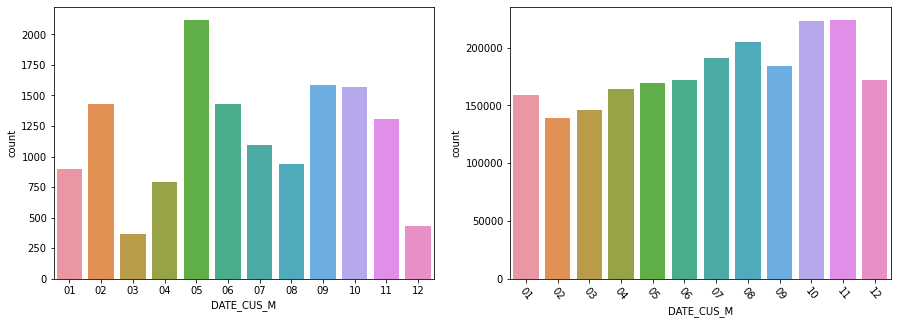

In [ ]:
# 1. 월별 적발 건수 2. 월별 총 물품 거래량
f, axes = plt.subplots(1,2, figsize=(15,5))

sns.countplot(idf['MONTH'], ax=axes[0],order=['01','02','03','04','05','06','07','08','09','10','11','12'])
sns.countplot(df['MONTH'], ax=axes[1],order=['01','02','03','04','05','06','07','08','09','10','11','12'])
plt.xticks(rotation = - 50 )
plt.show()